# PyTorch Lightning

PyTorch Lightning 提供了一个轻量级包装器，用于组织您的 PyTorch 代码，并轻松添加分布式训练和16位精度等高级功能。W&B 为记录 ML 实验提供了一个轻量级包装。但您不需要自己组合两者：Weights & Biases 通过 `WandbLogger` 直接集成到PyTorch Lightning库中。


## ⚡ Get going lightning-fast with just two lines.

```python
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb_logger = WandbLogger()
trainer = Trainer(logger=wandb_logger)
```


## Using PyTorch Lightning's WandbLogger

PyTorch Lightning 有一个 `WandbLogger` 类，可用于无缝记录指标、模型权重、媒体等。只需实例化 `WandbLogger` 并将其传递给 Lightning's `Trainer`。

```python
wandb_logger = WandbLogger()
trainer = Trainer(logger=wandb_logger)
```

## Logger arguments

以下是 `WandbLogger` 中一些最常用的参数，请参阅PyTorch Lightning WandbLogger文档以获取完整列表和描述

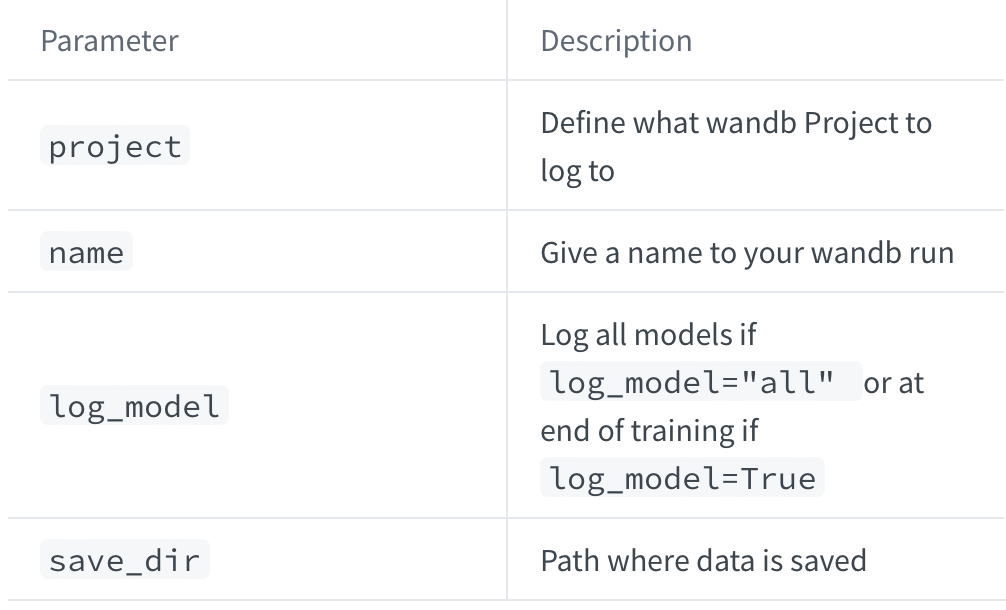

## Log your LightningModule hyperparameters


```python
class LitModule(LightningModule):
    def __init__(self, *args, **kwarg):
        self.save_hyperparameters()
```


## Log additional config parameters

```python
# add one parameter
wandb_logger.experiment.config["key"] = value

# add multiple parameters
wandb_logger.experiment.config.update({key1: val1, key2: val2})

# use directly wandb module
wandb.config["key"] = value
wandb.config.update()
```

## Log gradients, parameter histogram and model topology

您可以在训练时将模型对象传递给 `wandblogger.watch()`，以监控模型的梯度和参数。有关完整描述，请参阅PyTorch Lightning WandbLogger文档

### Log metrics

在使用 `WandbLogger` 时，您可以通过在 `LightningModule` 中调用 `self.log（'my_metric_name'，metric_vale）`，例如在 `training_step` 或 `valation_step` 方法中，将指标记录到W&B。

下面的代码片段展示了如何定义 `LightningModule` 来记录您的指标和 `LightningModule` 超参数。在本例中，我们将使用 `torchmetrics` 库来计算我们的指标


```python
import torch
from torch.nn import Linear, CrossEntropyLoss, functional as F
from torch.optim import Adam
from torchmetrics.functional import accuracy
from pytorch_lightning import LightningModule

class My_LitModule(LightningModule):
    def __init__(self, n_classes=10, n_layer_1=128, n_layer_2=256, lr=1e-3):
        super().__init__()
        
        self.layer_1 = Linear(28 * 28, n_layer_1)
        self.layer_2 = Linear(n_layer_1, n_layer_2)
        self.layer_3 = Linear(n_layer_2, n_classes)

        self.loss = CrossEntropyLoss()
        self.lr = lr

        self.save_hyperparameters()

    def forward(self, x):
        '''method used for inference input -> output'''
        
        # (b, 1, 28, 28) -> (b, 1*28*28)
        batch_size, channels, width, height = x.size()
        x = x.view(batch_size, -1)

        # let's do 3 x (linear + relu)
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x

    def training_step(self, batch, batch_idx):
        '''needs to return a loss from a single batch'''
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        '''used for logging metrics'''
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # Log loss and metric
        self.log('val_loss', loss)
        self.log('val_accuracy', acc)
        return preds

    def configure_optimizers(self):
        '''defines model optimizer'''
        return Adam(self.parameters(), lr=self.lr)

    def _get_preds_loss_accuracy(self, batch):
        '''convenience function since train/valid/test steps are similar'''
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        loss = self.loss(logits, y)
        acc = accuracy(preds, y)
        return preds, loss, acc
```

### Log images, text and more 

`WandbLogger` 具有 `log_image`、`log_text` 和 `log_table` 方法来记录媒体。

您还可以直接调用 `wandb.log` 或 `trainer.logger.experiment.log` 来记录其他媒体类型，如音频、分子、点云、3D对象等。

> 在 trainer 中使用 wandb.log 或 trainer.logger.experiment.log 时，请确保在正在传递的词典中也包含“global_step”：trainer.global_step。这样，您可以将当前正在记录的信息与其他方法记录的信息对齐。


```python
# using tensors, numpy arrays or PIL images
wandb_logger.log_image(key="samples", images=[img1, img2])

# adding captions
wandb_logger.log_image(key="samples", images=[img1, img2], caption=["tree", "person"])

# using file path
wandb_logger.log_image(key="samples", images=["img_1.jpg", "img_2.jpg"])

# using .log in the trainer
trainer.logger.experiment.log({
    "samples": [wandb.Image(img, caption=caption) 
    for (img, caption) in my_images]
})
```

```python
# data should be a list of lists
columns = ["input", "label", "prediction"]
my_data = [["cheese", "english", "english"], ["fromage", "french", "spanish"]]

# using columns and data
wandb_logger.log_text(key="my_samples", columns=columns, data=my_data)

# using a pandas DataFrame
wandb_logger.log_text(key="my_samples", dataframe=my_dataframe)
```

```python
# log a W&B Table that has a text caption, an image and audio
columns = ["caption", "image", "sound"]

# data should be a list of lists
my_data = [["cheese", wandb.Image(img_1), wandb.Audio(snd_1)], 
        ["wine", wandb.Image(img_2), wandb.Audio(snd_2)]]

# log the Table
wandb_logger.log_table(key="my_samples", columns=columns, data=data)
```

您可以使用 Lightning's Callbacks  系统来控制您何时通过 WandbLogger 登录 Weights & Biases，在本例中，我们记录了验证图像和预测的示例：

```python
import torch
import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

class LogPredictionSamplesCallback(Callback):
    
    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        """Called when the validation batch ends."""
 
        # `outputs` comes from `LightningModule.validation_step`
        # which corresponds to our model predictions in this case
        
        # Let's log 20 sample image predictions from the first batch
        if batch_idx == 0:
            n = 20
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {y_pred}' 
                for y_i, y_pred in zip(y[:n], outputs[:n])]
            
            
            # Option 1: log images with `WandbLogger.log_image`
            wandb_logger.log_image(
                key='sample_images', 
                images=images, 
                caption=captions)


            # Option 2: log images and predictions as a W&B Table
            columns = ['image', 'ground truth', 'prediction']
            data = [[wandb.Image(x_i), y_i, y_pred] f
                or x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
            wandb_logger.log_table(
                key='sample_table',
                columns=columns,
                data=data)            
...

trainer = pl.Trainer(
    ...
    callbacks=[LogPredictionSamplesCallback()]
)
```

## How to use multiple GPUs with Lightning and W&B?

PyTorch Lightning 通过其 DDP 接口支持多GPU。然而，PyTorch Lightning的设计要求我们小心如何实例化GPU。

Lightning 假设训练循环中的每个GPU（或Rank）必须以完全相同的方式实例化-具有相同的初始条件。然而，只有排名0的进程才能访问 `wandb.run` 对象，对于非零 rank 进程：`wandb.run = None`。这可能会导致您的非零进程失败。这种情况可能会使您陷入僵局，因为 rank 0 进程将等待非零 rank 进程加入，这些进程已经崩溃。

因此，我们必须小心如何设置我们的训练代码。建议的设置方法是让您的代码独立于 `wandb.run` 对象。

```python
class MNISTClassifier(pl.LightningModule):
    def __init__(self):
        super(MNISTClassifier, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
        
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        
        self.log("train/loss", loss)
        return {"train_loss": loss}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)
        
        self.log("val/loss", loss)
        return {"val_loss": loss}
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

def main():
    # Setting all the random seeds to the same value.
    # This is important in a distributed training setting. 
    # Each rank will get its own set of initial weights. 
    # If they don't match up, the gradients will not match either,
    # leading to training that may not converge.
    pl.seed_everything(1)

    train_loader = DataLoader(train_dataset,  batch_size = 64, 
                              shuffle = True, 
                              num_workers = 4)
    val_loader = DataLoader(val_dataset, 
                            batch_size = 64, 
                            shuffle = False, 
                            num_workers = 4)

    model = MNISTClassifier()
    wandb_logger = WandbLogger(project = "<project_name>")
    callbacks = [
        ModelCheckpoint(
            dirpath = "checkpoints",
            every_n_train_steps=100,
        ),
    ]
    trainer = pl.Trainer(
        max_epochs = 3, 
        gpus = 2, 
        logger = wandb_logger, 
        strategy="ddp", 
        callbacks=callbacks
    ) 
    trainer.fit(model, train_loader, val_loader)
```

## How does W&B integrate with Lightning?

核心集成基于 Lightning loggers API，它允许您以与框架无关的方式编写大部分日志代码。记录器传递给 ` Lightning Trainer` ，并根据该 API 丰富的 ` hook-and-callback system` 触发。这使您的研究代码与工程和日志代码完全分离。


## What does the integration log without any additional code?

我们将将您的 model checkpoints 保存到W&B，您可以在那里查看或下载它们以供将来运行。我们还将捕获系统指标，如GPU使用情况和网络I/O，环境信息，如硬件和操作系统信息，代码状态（包括git提交和差异补丁，笔记本内容和会话历史记录），以及打印的标准输出。

## What if I really need to use wandb.run in my training setup?

您必须从本质上扩展自己访问所需的变量的范围。换句话说，确保所有流程的初始条件都相同。

```python
if os.environ.get("LOCAL_RANK", None) is None:
    os.environ["WANDB_DIR"] = wandb.run.dir
```

然后，您可以使用 `os.environ["WANDB_DIR"]` 设置 model checkpoints 目录。这样，`wandb.run.dir` 也可以用于任何非零 rank 进程。